### **Hotel Booking Cancellation Prediction**

As stated in the brief, my goal for this project is to develop a machine learning model for predicting hotel booking cancellations. I will demonstrate my skill in data preprocessing, exploratory data analysis (EDA), feature engineering, and model training. I will handle a real-world dataset, address inconsistencies, and gain insights through visualisations. Finally, I will create a classifier that passes the 70% accuracy requirement and explain how characteristics affect the model's performance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
#reading the CSV file

fulldata_df = df = pd.read_csv('hotel_bookings.csv')

Firstly, i am dropping some columns which are redundant and offer little value such as:
*   **`reservation_status_date`**: The date of the last update isn't needed because we already have the reservation status
*   **`arrival_date_year`**: The year isn't as important since we already have the month
*   **`company`**: Too many missing values and it doesn't add useful information to the model
*   **`reservation_status`**: We already have a target column (is_canceled) that also has this information.
*   **`agent`**: This column has too many different agent IDs, which makes it complicated, and it doesn't  really help predict cancellations much
*   **`distribution_channel`**: This column has little flexibility and does not provide much insight into whether a booking will be cancelled.
*   **`days_in_waiting_list`**: This column has minimal influence on cancellations and introduces unnecessary noise into the dataset
*   **`country`**: The country information does not significantly affect cancellations in this context and adds unnecessary complexity to the model
*   **`required_car_parking_spaces`**: The number of parking spaces required is unlikely to affect whether a booking is canceled, and therefore, it was dropped.

By deleting these columns, I guarantee that the dataset remains focused on the most important attributes, simplifying the model and enhancing its performance while eliminating unnecessary data.









In [3]:
#Dropping these columns as they are not needed
fulldata_df = fulldata_df.drop(columns=[
    'reservation_status_date',
    'arrival_date_year',
    'company',
    'agent',
    'country',
    'reservation_status',
    'distribution_channel',
    'days_in_waiting_list',
    'required_car_parking_spaces',
])


###**Data Pre Processing**
*   Checking the dataframe for missing values
*   A basic data summary of the dataset to get insights of the numerical and categorical features
*   Filling the missing values with the most frequent values in the columns
* Extracting the key and valuable insights



**1.1 - Checking and Filling Missing values**

In this step, I began by looking closely at the dataset to better understand its structure and any missing data. To begin, I examined each column's data types to ensure that everything was properly structured and consistent. This is crucial because if the data types are incorrect, it may cause problems later when I begin processing the data. For example, columns like `is_canceled`, `lead_time`, and `adults` are of type `int64`, which is appropriate since they represent numerical values. On the other hand, columns like `hotel`, `meal`, and `customer_type` are of type `object`, meaning they contain categorical data.

I also calculated the total number of missing values in each column, and found that only the `children` column has missing values—specifically, `4` missing entries. This step is very important for identifying any gaps in the data that need to be filled or managed before moving forward with building the model

Finally, I printed out the initial shape of the dataset. This gives a quick view of the dataset’s size and allows me to keep track of any changes that happen as I clean and process the data. It’s important to know what I'm starting with so that I can make informed decisions during the process

In [4]:
#outputting the columns and their data types
print("Columns and Data Types:")
print(fulldata_df.dtypes)

#calculating total number of missing values
missing_values = fulldata_df.isnull().sum()
print("\nTotal Missing Values in Each Column:")
print(missing_values[missing_values > 0])

#outputs the initial shape of the dataframe before cleaning
print("Initial Shape of the DataFrame:", fulldata_df.shape)


Columns and Data Types:
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
customer_type                      object
adr                               float64
total_of_special_requests           int64
dtype: obj

**1.2 - Handling the missing values**

After identifying the missing values, I addressed them using the appropriate processes for the kind of data in each column. For numerical columns, I picked the median since it is less impacted by outliers than the mean. This guarantees that the data's central trend is kept and not distorted by extreme numbers. For categorical columns, I utilised the mode, which reflects the most common value. Filling in blank values using the mode guarantees that the most common category is allocated, which helps to preserve categorical consistency

I double-checked the dataset after using these techniques to make sure that all missing values had been addressed. Since there are no longer any missing values in any of the columns, the output indicates that the data is ready for additional analysis and model construction. By ensuring that both numerical and categorical data are handled correctly, this method preserves the dataset's integrity and avoids skewed outcomes in the next stages


In [5]:
#filling missing values in the numerical columns with the median
numerical_cols = fulldata_df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    median_value = fulldata_df[col].median()
    fulldata_df[col] = fulldata_df[col].fillna(median_value)#assigning the filled values back


#filling missing values in the categorical columns with the mode
categorical_cols = fulldata_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_value = fulldata_df[col].mode()[0]  #mode() returns a series,[0] takes the first value
    fulldata_df[col] = fulldata_df[col].fillna(mode_value)  #assigning the filled values back

#making sure that all missing values have been handled
print("\nMissing values after handling:")
print(fulldata_df.isnull().sum())


Missing values after handling:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
customer_type                     0
adr                               0
total_of_special_requests         0
dtype: int64


**1.3 - Discovering inconsistent values**

In Section 1.3, I reviewed the unique values in my dataset and identified several inconsistencies. The `adults` column contains unusually high values, such as `40` and `50`, which can indicate data entry errors or reflect group bookings. The `children` and `babies` columns also have a maximum value of `10`, suggesting excessive counts for individual reservations.

Extreme values in the `lead_time` column, with some bookings made up to `737` days in advance, indicate potential anomalies. Also, I found `180` incomplete bookings where all counts for adults, children, and babies were zero, alongside `715` records of invalid stays with both stay counts at zero.

Another error would be from the `distribution_channel`, which has `undefined` values, and the `meal` column, where `SC` (self-catering option) is represented as both `SC` and `Undefined`. This inconsistency may lead to inaccurate analysis and misrepresent guest preferences. Overall, these findings emphasize the need for the comprehensive data cleaning to ensure the integrity and reliability of my dataset for further analysis.

In [6]:
#finding the unique values in columns to identify inconsistencies
for col in fulldata_df.columns:
    unique_values = fulldata_df[col].unique()
    print(f"\nUnique Values in '{col}':")
    print(unique_values)


Unique Values in 'hotel':
['Resort Hotel' 'City Hotel']

Unique Values in 'is_canceled':
[0 1]

Unique Values in 'lead_time':
[342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 152 354 347 158 185 349 183 352 177 200 1

In [7]:
#checking for incomplete bookings (zero adults, children, or babies)
incomplete_bookings = fulldata_df[(fulldata_df['adults'] == 0) &
                                   (fulldata_df['children'] == 0) &
                                   (fulldata_df['babies'] == 0)]
print(f"\nNumber of Incomplete Bookings (zero adults, children, or babies): {len(incomplete_bookings)}")

#checking for stays with zeros in both 'stays_in_weekend_nights' and 'stays_in_week_nights'
invalid_stays = fulldata_df[(fulldata_df['stays_in_weekend_nights'] == 0) &
                             (fulldata_df['stays_in_week_nights'] == 0)]
print(f"\nNumber of Records with Invalid Stays (zeros in both nights): {len(invalid_stays)}")

#checking how many occurrences of 'undefined' in the 'meal' column
undefined_meal_count = (fulldata_df['meal'] == 'Undefined').sum()
sc_meal_count = (fulldata_df['meal'] == 'SC').sum()
print(f"Number of 'Undefined' values in 'meal': {undefined_meal_count}")
print(f"Number of 'SC' values in 'meal': {sc_meal_count}")

#checking extreme values for 'lead_time'
extreme_lead_time_count = (fulldata_df['lead_time'] > 400).sum()
print(f"\nNumber of Extreme Values in 'lead_time': {extreme_lead_time_count}")

#checking high values for 'adults', 'children', and 'babies'
high_adults_count = (fulldata_df['adults'] > 10).sum()
high_children_count = (fulldata_df['children'] > 5).sum()
high_babies_count = (fulldata_df['babies'] > 5).sum()
print(f"Number of high values in 'adults': {high_adults_count}")
print(f"Number of high values in 'children': {high_children_count}")
print(f"Number of high values in 'babies': {high_babies_count}")



Number of Incomplete Bookings (zero adults, children, or babies): 180

Number of Records with Invalid Stays (zeros in both nights): 715
Number of 'Undefined' values in 'meal': 1169
Number of 'SC' values in 'meal': 10650

Number of Extreme Values in 'lead_time': 2114
Number of high values in 'adults': 12
Number of high values in 'children': 1
Number of high values in 'babies': 2


The dataset has a number of data quality problems, as the output shows. There are `715` records with invalid stay durations that need to be deleted, and `180` incomplete bookings with no adults, kids, or infants. In addition, there are `1169` `undefined` values in the `meal` column and `5` undefined values in the `distribution_channel`. This is concerning because in the `meal` column, `SC` appears `10650` times, indicating that they may belong to the same category. Also,there are outliers in the high values of in the `children` and `babies` which should be removed. All in all, these changes would help in making the dataset more accurate.

<Axes: >

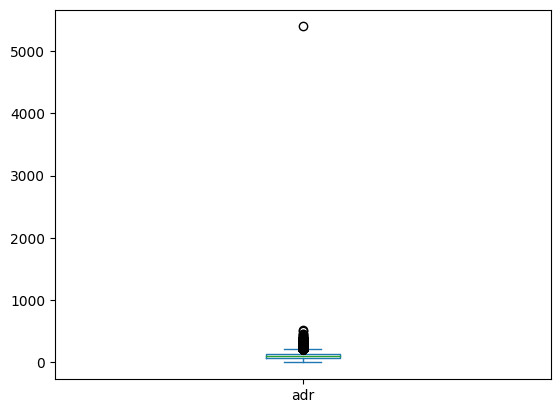

In [8]:
fulldata_df.plot(y=['adr'], kind='box')

This box plot represents the distribution of the `adr` (Average Daily Rate), which indicates the average daily price paid by customers for their hotel bookings
*   Median: The median ADR is shown by the thick line inside the box, which shows that the majority of the daily rates are grouped around a comparatively low figure
*   Interquartile Range (IQR): The box captures the middle 50% of the data, ranging from the 25th to the 75th percentile. The relatively small height of the box shows that most ADR values are tightly packed within a narrow range, suggesting consistency in most of the hotel's daily rates
*   Whiskers: The lines extending from the box (whiskers) represent the range of data excluding outliers. Most values fall below the upper whisker, suggesting that a majority of bookings have an ADR below this point
*   Outliers: The circles above the upper whisker represent outliers, with one extreme outlier standing out significantly above 5000. This indicates that there is at least one booking with an unusually high daily rate, far above what would be expected based on the rest of the data

An anomaly that can skew the results is the extreme value at the top (over 5000). In contrast to the bulk of the ADR values, which are closely clustered within a considerably lower range, this outlier is abnormally high. I'll eliminate this anomaly from the dataset so it doesn't distort the analysis. By doing this, I preserve the overall integrity and distribution of the remaining data while ensuring that the model's predictions are not unduly impacted by this one extreme value






<Axes: >

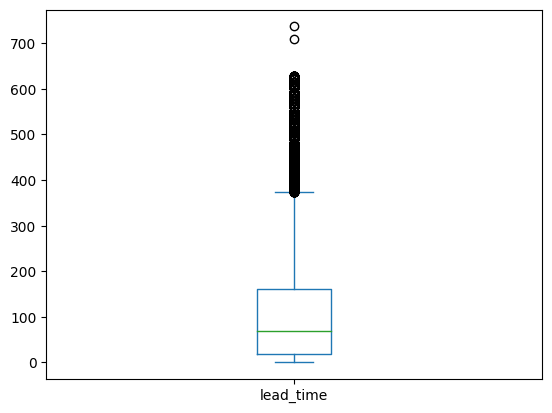

In [9]:
fulldata_df.plot(y=['lead_time'], kind='box')

The box plot shown here represents the distribution of the `lead_time` variable, which indicates the number of days between the booking date and the arrival date. The plot helps in visualizing the spread and identifying any outliers in the data
*   **Median:** The thick green line inside the box represents the median lead_time, which shows the middle value of the dataset. Most bookings have a lead_time lower than the median.
*   **Interquartile Range (IQR):** The centre 50% of the data is contained in the interquartile range, which is shown by the box. The 25th percentile is at the bottom of the box, and the 75th percentile is at the top. This range contains the majority of the data
*   **Whiskers:** The lines extending from the box (whiskers) show the range of the data excluding outliers In this case, values fall mostly below around 400 days
*   **Outliers:** The circles above the upper whisker represent outliers, which are values that lie significantly outside the typical range of the data. These outliers occur for bookings with extremely high lead_time, above 400 days

I made the decision to set the `lead_time` at 630 days due to the existence of outliers. The outliers in the plot (beyond the upper whisker) are severe situations that can distort the study, which is why this cap was selected. I may lessen the impact of these outliers and produce a more reliable and general-purpose model by restricting the values. This enhances the model's overall performance by preventing it from becoming unduly sensitive to uncommon, extreme values.






**1.4 - Addressing and Removing Inconsistencies**

I dropped records where the booking has zero adults, children, and babies because keeping these records can lead to misleading analyses and predictions. I also removed entries where both `stays_in_weekend_nights` and `stays_in_week_nights` are zero, as they indicate that no nights were booked because they do not make sense. A booking should always include atleast one night of stay. I  also capped the `lead_time` at 630 days to remove the extreme values that could impact analysis, as bookings made far in advance are outliers and likely special cases. I also merged the `Undefined` and `SC` values in the `meal` column since they both represent the same category, reducing redundancy. Also, I removed bookings where there were high values of `children` and `babies`.Lastly, I dropped the few cases where `distribution_channel` was marked as `Undefined` to maintain the data clarity, as the values were outliers.

By removing these entries, I made sure that the dataset reflects actual bookings.

In [10]:
##removing any incomplete bookings with zero adults, children, and babies
fulldata_df = fulldata_df[~((fulldata_df['adults'] == 0) &
                             (fulldata_df['children'] == 0) &
                             (fulldata_df['babies'] == 0))]

#removing any invalid stay records with zeros in both stays
fulldata_df = fulldata_df[~((fulldata_df['stays_in_weekend_nights'] == 0) &
                             (fulldata_df['stays_in_week_nights'] == 0))]

# Removing high values for 'children' and 'babies'
fulldata_df = fulldata_df[(fulldata_df['children'] <= 5) & (fulldata_df['babies'] <= 5)]

#capping extreme values in 'lead_time'
fulldata_df['lead_time'] = fulldata_df['lead_time'].clip(upper=550)

#capping extreme values in 'lead_time'
fulldata_df['adr'] = fulldata_df['adr'].clip(upper=350)
#fulldata_df = fulldata_df[fulldata_df['adr'] <= 225]

#merging the 2 meal columns together into the SC column as it has more
fulldata_df['meal'] = fulldata_df['meal'].replace({'Undefined': 'SC',})
fulldata_df['meal'] = pd.Categorical(fulldata_df['meal'])

#verifying the merged meal column
meal_value_counts = fulldata_df['meal'].value_counts()
print(f"Meal column unique values and their counts after cleaning:\n{meal_value_counts}")


print(f"Shape of DataFrame after cleaning: {fulldata_df.shape}")


<ipython-input-10-ab3d0c5a12f1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulldata_df['lead_time'] = fulldata_df['lead_time'].clip(upper=550)
<ipython-input-10-ab3d0c5a12f1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulldata_df['adr'] = fulldata_df['adr'].clip(upper=350)
<ipython-input-10-ab3d0c5a12f1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Meal column unique values and their counts after cleaning:
meal
BB    91718
HB    14384
SC    11663
FB      797
Name: count, dtype: int64
Shape of DataFrame after cleaning: (118562, 23)


**1.5 - Column data type conversion**

In 1.5, I took a closer look at the dataFrame data types and realized that I could make some changes to improve efficiency. I decided to convert several columns to the `category` data type, like `hotel`, `arrival_date_month`, and `meal`, because they only had a handful of unique values. This change not only helped save memory but also sped up my analysis. I also noticed that the `children` column was set as `float64`, even though it only contained whole numbers and also you cant have a decimal of a child.

By converting the columns `is_canceled` and `is_repeated_guest` to boolean data types (True/False), enhances readability, making it clearer to see False for not canceled and True for canceled, rather than interpreting 0 and 1. Additionally, boolean values are more memory-efficient, which is important for large datasets, and they simplify logical operations, making my code cleaner. By implementing this change, I can improve the clarity and efficiency of my dataset for future analyses and visualizations. To make things clearer and more accurate, I converted it to `int64`. Overall, these adjustments made sure that each columns data types were accurate and make proccessing more efficient.

In [11]:
#converting object columns to category
categorical_columns = [
    'hotel',
    'meal',
    'market_segment',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'customer_type'
]

for col in categorical_columns:
    fulldata_df[col] = fulldata_df[col].astype('category')

#converting children from float64 to int64 if appropriate
if fulldata_df['children'].notnull().all() and (fulldata_df['children'] % 1 == 0).all():
    fulldata_df['children'] = fulldata_df['children'].astype('int64')

#converting 'is_canceled' and 'is_repeated_guest' to boolean
fulldata_df['is_canceled'] = fulldata_df['is_canceled'].astype(bool)
fulldata_df['is_repeated_guest'] = fulldata_df['is_repeated_guest'].astype(bool)


#check the new data types
print(fulldata_df.dtypes)


hotel                             category
is_canceled                           bool
lead_time                            int64
arrival_date_month                  object
arrival_date_week_number             int64
arrival_date_day_of_month            int64
stays_in_weekend_nights              int64
stays_in_week_nights                 int64
adults                               int64
children                             int64
babies                               int64
meal                              category
market_segment                    category
is_repeated_guest                     bool
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                category
assigned_room_type                category
booking_changes                      int64
deposit_type                      category
customer_type                     category
adr                                float64
total_of_special_requests            int64
dtype: obje

# **Exploratory Data Analysis (EDA):**


**2.1 - Calculating Cancellation Percentages for City and Resort Hotels**

In the output of **2.1**, I observed the cancellation percentages for both City and Resort hotels. The data below reveals that City Hotels have a cancellation rate of approximately `41.9%`, while Resort Hotels show a significantly lower cancellation rate of about `28.0%`. The bar graph visually represents this data, making it clear that City Hotels experience a higher percentage of cancellations compared to Resort Hotels. This insight leads me to think that City Hotels may face greater challenges regarding booking reliability. I find it important for hotel management to investigate the underlying factors causing these cancellations, such as pricing strategies, customer satisfaction etc. The visible contrast in cancellation rates emphasizes the need for tailored strategies for each hotel type to effectively mitigate against cancellations.

The reason why i chose a bar graph is because it effectively compares the 2 categories, allowing us to see the differences in cancellation percentages between city and resort hotels clearly.It is also striaghforward and easy to interpret and allow the management to quickly identify which hotel has the higher or lower cancellation percentage

Cancellation Percentages:
 is_canceled       False      True 
hotel                             
City Hotel    58.089661  41.910339
Resort Hotel  71.992941  28.007059


<Figure size 1000x600 with 0 Axes>

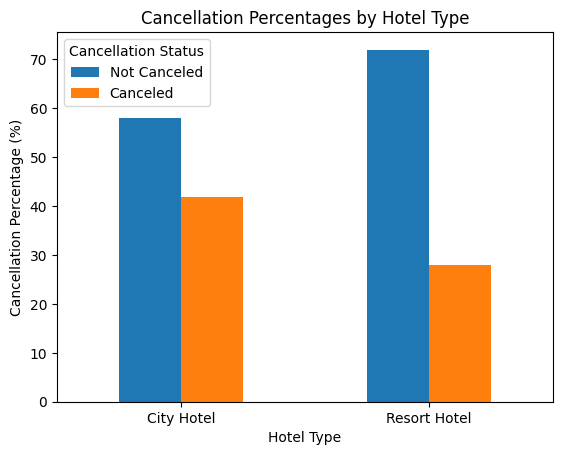

In [12]:
#calculating cancellation percentages for the city and resort hotels
cancellation_counts = fulldata_df.pivot_table(index='hotel',
                                              columns='is_canceled',
                                              aggfunc='size',
                                              fill_value=0 ,
                                              observed=False
                                              )

cancellation_percentages = cancellation_counts.div(cancellation_counts.sum(axis=1), axis=0) * 100
#printing cancellation percentages for better understanding
print("Cancellation Percentages:\n", cancellation_percentages)

#visualization - Bar Graph for Cancellation Percentages
plt.figure(figsize=(10, 6))
cancellation_percentages.plot(kind='bar', stacked=False)
plt.title('Cancellation Percentages by Hotel Type')
plt.xlabel('Hotel Type')
plt.ylabel('Cancellation Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()

**2.2 - Identifying the most frequently ordered meal types**

From the pie chart, several key insights can be inferred about the meal preferences of hotel guests:

* **Dominance of Bed & Breakfast (BB)**: The vast majority of
guests `77.4%` prefer the Bed & Breakfast (BB) option. This suggests that most guests favor a simple, convenient meal arrangement where breakfast is included, but they prefer flexibility for other meals. It could also indicate that guests often dine outside the hotel for lunch and dinner or prefer more independent options during their stay

* **Limited Popularity of Full Board (FB):** Only `0.7%` of guests choose the Full Board (FB) option, which includes all meals (breakfast, lunch, and dinner). This low percentage could indicate that guests are not inclined to commit to a full day of meals at the hotel, perhaps because they prefer exploring local dining options or want more freedom in their schedules

* **Moderate Popularity of Half Board (HB) and Self Catering (SC):** About `12.1%` of guests prefer the Half Board (HB) option, which typically includes breakfast and dinner, offering a balance between convenience and flexibility. Another `9.8%` opt for Self Catering (SC), suggesting that a portion of guests, especially those staying longer or with families, may want the freedom to prepare their own meals, possibly to save costs or meet specific dietary preferences

* **Business Implications:** These insights could guide hotel management in adjusting their offerings or marketing strategies. Since BB is overwhelmingly the most popular choice, the hotel might want to focus more on promoting breakfast options or enhancing that experience. On the other hand, the low demand for Full Board could suggest that there’s little point in heavily promoting this option, or it may be an opportunity to innovate and make Full Board more attractive through pricing strategies or enhanced meal options

A pie chart was used because it clearly illustrates the percentage of each meal type in relation to the total, the pie chart was selected as the best visualisation technique. When attempting to highlight specific aspects of a whole, a pie chart is especially helpful. In this instance, it makes it evident that most customers like the BB choice. Given that there are just a few categories (meal kinds), the chart makes it simple to quickly assess the relative popularity of each meal type. Pie charts are the best option for this kind of categorical data since they make it easy for the reader to identify which meal types are more and less popular

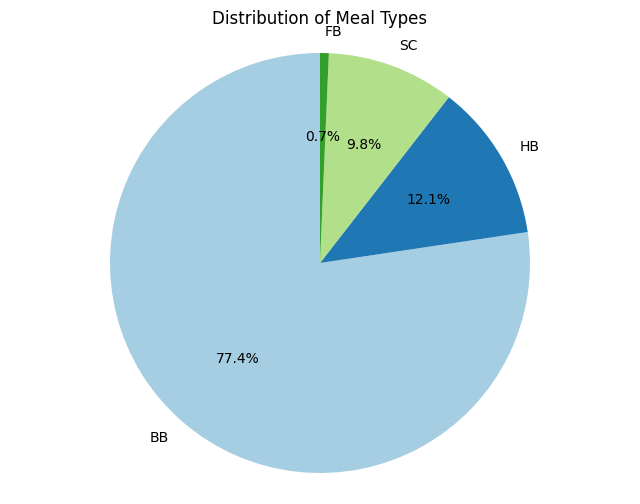

In [13]:
#count the occurrences of each meal type (this can be the same as in the verification step)
meal_value_counts = fulldata_df['meal'].value_counts()

#create a pie chart for the meal types using meal_value_counts
plt.figure(figsize=(8, 6))
plt.pie(meal_value_counts, labels=meal_value_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Meal Types')
plt.axis('equal')  #equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**2.3 - Determining the number of returning guests**

This pie chart illustrates the proportion of returning guests versus new guests at the hotel and from the chart and data, we can infer the following :

New Guests dominate the dataset, accounting for `97%` of the total, while Returning Guests represent just `3%`.
This indicates that the hotel primarily serves first-time visitors and has a relatively low percentage of repeat customers. This insight can help the hotel focus on strategies to encourage guest loyalty and improve customer retention. For example, introducing loyalty programs, special discounts for returning guests, or enhancing the overall guest experience could help increase the proportion of returning guests

For this visualisation, a pie chart was selected since it clearly shows the percentage of new vs returning visitors as components of a whole. A pie chart offers a quick and easy comparison of the relative sizes of each group because there are just two categories (new and returning guests). It makes it simple to understand the hotel's guest composition at a glance by graphically highlighting the overwhelming dominance of new guests (`97%`) over returning guests (`3%`)


Number of Returning Guests and New Guests:
is_repeated_guest
False    115063
True       3499
Name: count, dtype: int64


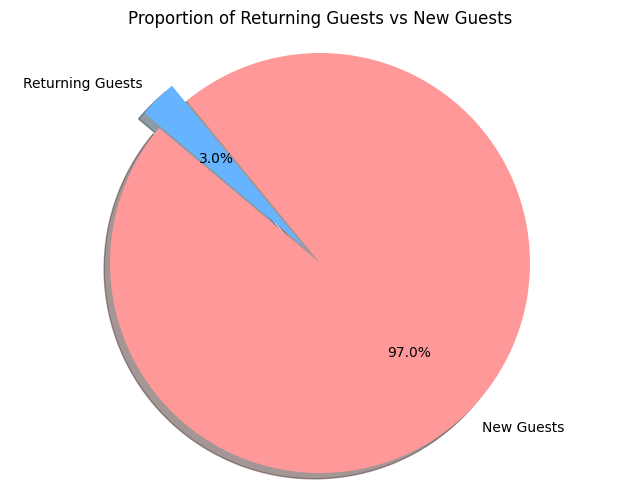

In [14]:
#count the number of returning guests
returning_guests_count = fulldata_df['is_repeated_guest'].value_counts()

#print the number of returning and new guests
print("Number of Returning Guests and New Guests:")
print(returning_guests_count)

#define labels and sizes for the pie chart
labels = ['New Guests', 'Returning Guests']
sizes = returning_guests_count.values
colors = ['#ff9999','#66b3ff']  #color scheme for the pie chart
explode = (0.1, 0)  #explode the 1st slice (Returning Guests)

#create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  #equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Returning Guests vs New Guests')
plt.show()


**2.4 - Discovering the most booked room types**

The data on room type bookings provides several key insights into customer preferences and hotel room demand:

*  **High Demand for Room Type A:** Room Type A is
overwhelmingly the most popular, accounting for the vast majority of bookings (`85,397`). This suggests that Room Type A either offers the best value, meets most customers' needs, or has the largest availability within the hotel. It may be a standard room that suits the majority of guests, and the hotel likely focuses its inventory on this type

*   **Significant Drop to Room Type D:** Room Type D is the second most popular, with `19,094` bookings, but there is a sharp decline in demand compared to Room Type A. This sharp drop suggests that Room Type A is the dominant choice, and there may be specific reasons (price, amenities, etc.) why Room Type D is less preferred

*  **Lower Demand for Other Room Types:** The other room types (E, F, G, etc.) have far fewer bookings, with Room Type E having just `6,482` bookings, and others gradually decreasing. This could mean that these room types are more niche or specialized, appealing to a smaller segment of guests, or that they are less available or priced higher, making them less attractive to most guests

*  **Minimal Interest in Room Type L:** Room Type L has only `6` bookings, indicating that it is either very rarely offered or in very low demand. This might reflect a high price point, special features, or simply low availability

I chose a Line chart because it clearly illustrates the ranking and the sharp decline in reservations from one room type to the next. It is easy to see the stark contrast between Room Type A and every other type of room because the line makes this evident. The best option for presenting the room type distribution in an understandable manner is a line chart, which excels at illustrating patterns and relative differences. Compared to a bar chart or other visualisations, this approach makes the steep slope between Room Type A and D and the subsequent slow fall more apparent.





Most Booked Room Types:
reserved_room_type
A    85397
D    19094
E     6482
F     2879
G     2074
B     1110
C      923
H      597
L        6
Name: count, dtype: int64


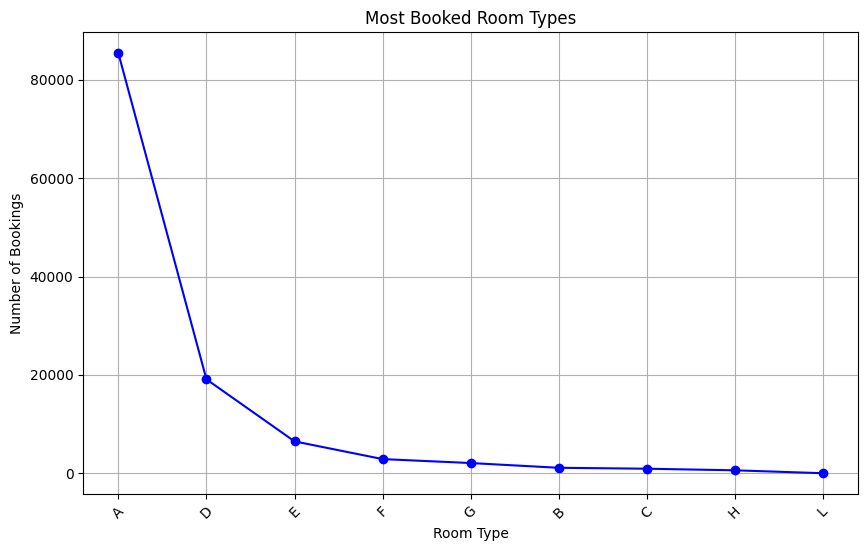

In [15]:
#count the number of bookings for each room type
room_type_counts = fulldata_df['reserved_room_type'].value_counts().sort_index()

#filter out room types with zero bookings
room_type_counts = room_type_counts[room_type_counts > 0]

#sort the values in descending order
room_type_counts = room_type_counts.sort_values(ascending=False)

#print the most booked room types
print("Most Booked Room Types:")
print(room_type_counts)

#visualization: Line chart for the most booked room types
import matplotlib.pyplot as plt

#create a line chart
plt.figure(figsize=(10, 6))
room_type_counts.plot(kind='line', marker='o', color='b')
plt.title('Most Booked Room Types')
plt.xlabel('Room Type')
plt.ylabel('Number of Bookings')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**2.5 - Exploring correlations between room types and cancellations**

In this code, I first mapped the reserved and assigned room types to numeric values to facilitate the calculation of correlations. I then computed a correlation matrix that examines the relationships between reserved room types, assigned room types, and cancellation rates. Finally, I visualized the correlation matrix using a heatmap to display the strength of these relationships. The heatmap shows the correlation coefficients, with darker colours representing stronger correlations

*   **Strong Positive Correlation (`0.73`) Between Reserved and Assigned Room Types:** There is a strong correlation between the room type a guest reserves and the room type they are assigned. This indicates that in the majority of cases, guests are assigned the exact room type they booked, reflecting consistency in the hotel's room allocation practices. This suggests that reassignment to a different room type is relatively rare

*   **Weak Negative Correlation with Cancellations:**
 There are weak negative associations between cancellation rates and the type of room that was reserved and the type of room that was assigned. There is a `-0.057` link between the kind of reserved room and cancellations, and a `-0.12` correlation between the type of allocated room and cancellations. This implies that a guest's decision to cancel their reservation is not significantly impacted by the sort of accommodation they were assigned or the one they had reserved. Practically speaking, this indicates that cancellations are probably caused by other reasons besides discontent with room assignments, such as individual plans, cost, outside events, or contentment with other hotel amenities

*  **Room Reassignment Has Little Impact on Cancellations:** Given the weak correlation between assigned room type and cancellations, we can infer that even in cases where guests are not assigned the room type they reserved, this mismatch does not significantly contribute to cancellation decisions. This might suggest that guests are generally flexible about receiving different room types or that the differences between room types are not substantial enough to influence their decision to cancel

Because it offers a clear, visual depiction of the relationships between the three variables (cancellations, allocated room types, and reserved room types), the heatmap was selected. Heatmaps are very useful for showing correlation matrices since their colour gradients make it simple to identify patterns. In this instance, the heatmap rapidly draws attention to the significantly weaker associations with cancellations (in lighter blue) and the large correlations with reserved and assigned room types (in darker blue). This eliminates the need to examine individual correlation values and provides an instant insight of where strong associations exist and where they do not. It makes comparing several variables easier and conveys the connections in an understandable way.



<ipython-input-16-54ea10de3832>:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cancellation_rate_pivot = fulldata_df.pivot_table(index='reserved_room_numeric', columns='assigned_room_numeric', values='is_canceled', aggfunc='mean')


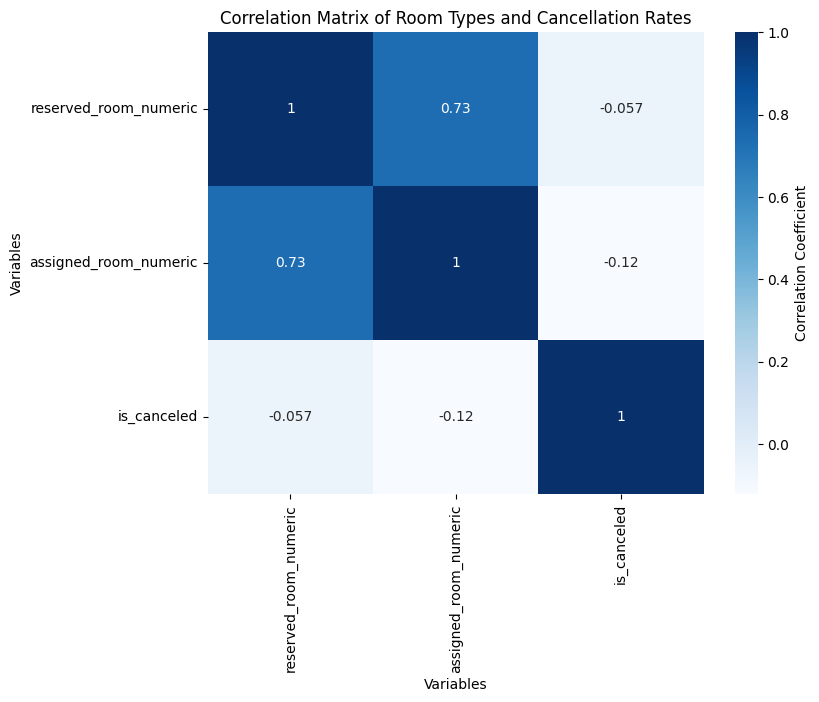

In [16]:
#map reserved room types to numeric values
room_type_mapping = {room_type: idx for idx, room_type in enumerate(fulldata_df['reserved_room_type'].unique())}
fulldata_df['reserved_room_numeric'] = fulldata_df['reserved_room_type'].map(room_type_mapping)

#manually map assigned room types to numeric values
assigned_type_mapping = {room_type: idx for idx, room_type in enumerate(fulldata_df['assigned_room_type'].unique())}
fulldata_df['assigned_room_numeric'] = fulldata_df['assigned_room_type'].map(assigned_type_mapping)

#create a pivot table for cancellation rates
cancellation_rate_pivot = fulldata_df.pivot_table(index='reserved_room_numeric', columns='assigned_room_numeric', values='is_canceled', aggfunc='mean')

#calculate the correlation matrix
correlation_matrix = fulldata_df[['reserved_room_numeric', 'assigned_room_numeric', 'is_canceled']].corr()

#plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Room Types and Cancellation Rates')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()


# 3. Feature Engineering (20%)

**3.1 - Binning**

In this feature engineering step, I applied binning to the lead_time and adr columns to handle skewed data and enhance interpretability. For lead_time, I categorized values into meaningful time periods ranging from `< 1 month` to `12-13 months` (capped), making it easier to analyze booking patterns. For the adr, I adjusted the bins to reflect the updated range, with categories such as `Budget (<$50)`, `Moderate ($50-100)`, `High ($100-200)`, `Premium ($200-300)`, and `Luxury ($300-350)`. This restructuring better captures the higher-end price segments and provides a clearer view of ADR distribution

Binning was necessary for the model because it helps reduce the impact of skewed data and outliers, which can distort predictions. By transforming continuous data into categorical ranges, the model can better capture patterns and relationships, especially for non-linear interactions between features and the target. The bins make features like ADR more interpretable, improving the model’s ability to generalize across different price ranges and lead times, which ultimately contributes to better performance. The binning was successfully applied, as shown in the verification output.



In [17]:
#assume lead_time values are capped at 550 days as part of the cleaning process
#adjust the bins to reflect the cap at 550 days for lead_time
bins_lead_time = [0, 30, 90, 180, 365, 550]
labels_lead_time = ['<1 month', '1-3 months', '3-6 months', '6-12 months', '12-13 months (capped)']
fulldata_df['lead_time_binned'] = pd.cut(df['lead_time'], bins=bins_lead_time, labels=labels_lead_time, right=False)

#binning 'adr' to handle skewed data
#custom bins for ADR based on meaningful price ranges
bins_adr = [0, 50, 100, 200, 350]
labels_adr = ['Budget (<$50)', 'Moderate ($50-100)', 'High ($100-200)', 'Premium ($200-300)' 'Luxury ($300-350)']
fulldata_df['adr_binned'] = pd.cut(fulldata_df['adr'], bins=bins_adr, labels=labels_adr, right=False)

#output to verify the binning
print(fulldata_df[['lead_time', 'lead_time_binned']])
print(fulldata_df[['adr', 'adr_binned']])

        lead_time lead_time_binned
2               7         <1 month
3              13         <1 month
4              14         <1 month
5              14         <1 month
6               0         <1 month
...           ...              ...
119385         23         <1 month
119386        102       3-6 months
119387         34       1-3 months
119388        109       3-6 months
119389        205      6-12 months

[118562 rows x 2 columns]
           adr                           adr_binned
2        75.00                   Moderate ($50-100)
3        75.00                   Moderate ($50-100)
4        98.00                   Moderate ($50-100)
5        98.00                   Moderate ($50-100)
6       107.00                      High ($100-200)
...        ...                                  ...
119385   96.14                   Moderate ($50-100)
119386  225.43  Premium ($200-300)Luxury ($300-350)
119387  157.71                      High ($100-200)
119388  104.40                   

**3.2 - Encoding**

In this step, I applied one-hot encoding to the categorical columns in the dataset. One-hot encoding is necessary to transform categorical variables into a numerical format that machine learning models can work with effectively. The categorical columns chosen for encoding include features like `hotel`, `meal`, `market_segment`, `reserved_room_type`, `assigned_room_type`, `deposit_type`, `customer_type`, as well as the previously binned columns, `lead_time_binned` and `adr_binned`

*   I specified the categorical columns to be encoded using the `pd.get_dummies()` function, which converts each category into a new column with binary values (0 or 1)

*   The parameter drop_first=True was used which prevents multicollinearity by dropping the first column from each category. Multicollinearity occurs when two or more independent variables in a model are highly correlated, which can distort the model’s estimates and reduce interpretability

*   The output confirms the encoding process by displaying the new column names and verifying the first few rows of the newly encoded dataframe, `fulldata_df_encoded`. Additionally, the shape of the dataframe is printed to show the total number of columns after encoding

This step is crucial because it converts categorical data into a numerical format without introducing order or rank among categories, allowing the model to process these features effectively




In [18]:
#columns to one-hot encode
categorical_columns = [
    'hotel', 'meal', 'market_segment',
    'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type', 'lead_time_binned', 'adr_binned'
]

#apply one-hot encoding to the specified columns in 'fulldata_df'
fulldata_df_encoded = pd.get_dummies(fulldata_df, columns=categorical_columns, drop_first=True) #prevents multicollinearity

#output results to check them
print(fulldata_df_encoded.columns)  # Display column names to verify new dummy columns
print(fulldata_df_encoded.head())   # Show the first few rows of the DataFrame
print(fulldata_df_encoded.shape)    # Check the total number of features/columns after encoding


Index(['is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'adr',
       'total_of_special_requests', 'reserved_room_numeric',
       'assigned_room_numeric', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB',
       'meal_SC', 'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Undefined', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'assigned_room_type_B', 'assigned_room_type_C',
       'assigned_room_type_D', 'a

**3.3 - Scaling**

In 3.3, I decided not to apply scaling to the dataset, and here's the reasoning behind this choice:

I chose not to apply scaling to the dataset for several reasons. First, the model being used is a decision tree, which is not sensitive to the scale of the features. Decision trees split the data based on thresholds, and these splits are determined by the feature values themselves, irrespective of their range. Therefore, scaling would not improve the model’s performance, as the decision tree focuses on feature importance and splits rather than distance-based calculations, which are affected by scaling in models like KNN or SVM

Additionally, in 3.2, i already performed one-hot encoding on categorical variables, which transformed the data into binary columns (0s and 1s). Since these encoded columns do not require scaling (they are already normalized between 0 and 1), scaling would provide no further benefit. Moreover, i have also binned certain features, like `lead_time` and `adr`, into categorical ranges, and also encoded them into bincary, making these features already uniform and eliminating the need for further scaling

so therefore, given the nature of the model of decision tree and the processing tasks that I have already done (one-hot encoding and binning), applying scaling was unnecessary

**3.4 - Feature Selection**

In this section, I calculated the correlation matrix for all numerical features in the dataset to identify highly correlated features and assess whether any features could be removed to reduce multicollinearity. The correlation matrix was visualized as a heatmap to make the relationships between features easier to interpret

*   `stays_in_weekend_nights` and `stays_in_week_nights`: These two features show a moderate positive correlation (0.49). While this correlation is not particularly high, it suggests that there is some overlap in the information these two features capture

*   `Weak Correlations Across the Board`: This indicates that there is no multicollinearity issue, and no features are strongly correlated with one another. As a result, all features provide unique information to the model

*  `adr` and `adults`: There is a small positive correlation (`0.24`) between the `adr` (Average Daily Rate) and `adults`, which suggests that bookings with more adults tend to have slightly higher average daily rates. However, this correlation is still quite weak and does not warrant any feature removal


Based on the analysis of the heatmap, i have decided to drop `arrival_date_month`, `arrival_date_week_number`, and `arrival_date_day_of_month` as they all showed very low correlations with the other features in the dataset, with correlation coefficients close to zero. This suggests that these features do not have a meaningful relationship with the target variable (cancellations)

By further removing these columns, it reduces the complexity and dimensionality of the dataset, which can improve the model’s performance, speed, and interpretability





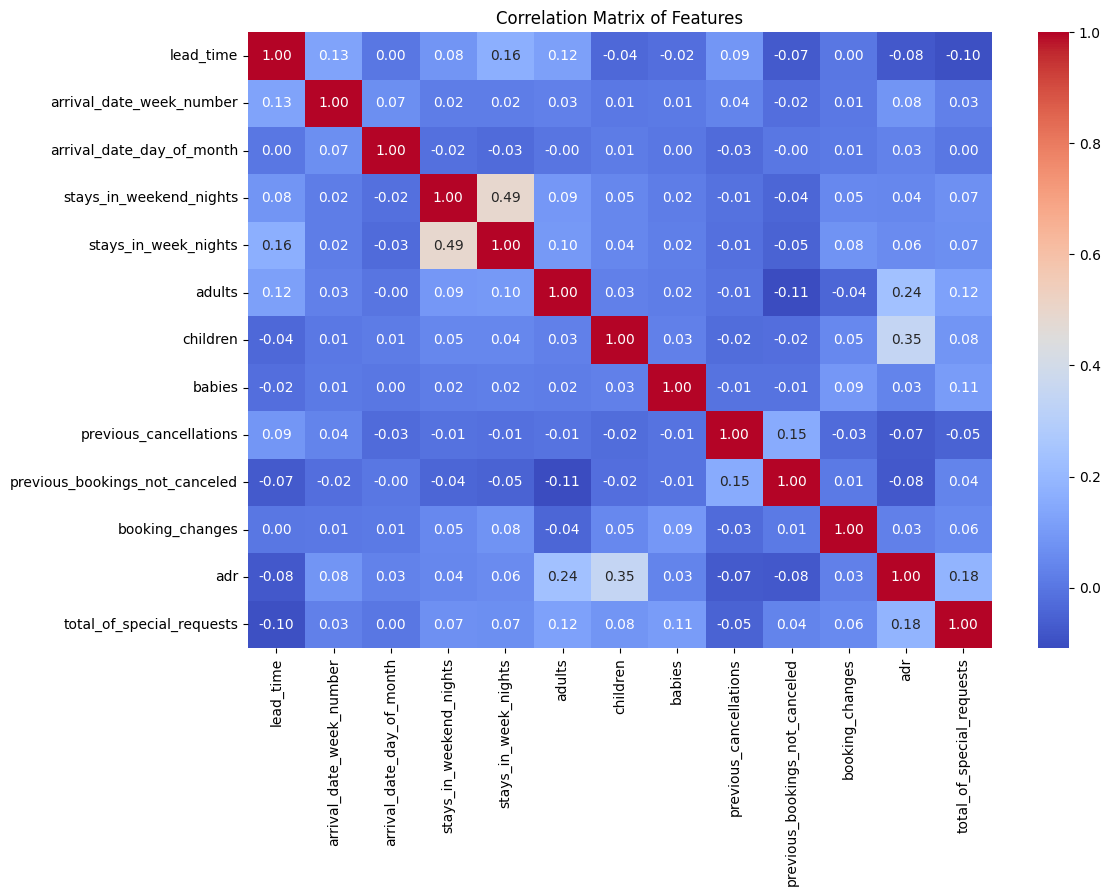

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#compute the correlation matrix, selecting only numerical features
#use np.number to refer to numeric types from numpy
corr_matrix = fulldata_df.select_dtypes(include=np.number).corr()

#visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

In [20]:
#dropping the columns from the dataframe
columns_to_drop = ['arrival_date_week_number', 'arrival_date_day_of_month', 'arrival_date_month']
fulldata_df_encoded = fulldata_df_encoded.drop(columns=columns_to_drop)

#verifying if the columns have been removed
print(fulldata_df_encoded.columns)

Index(['is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'adr',
       'total_of_special_requests', 'reserved_room_numeric',
       'assigned_room_numeric', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB',
       'meal_SC', 'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Undefined', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'assigned_room_type_B', 'assigned_room_type_C',
       'assigned_room_type_D', 'assigned_room_type_E', 'assigned_room_type_F',
       'assigned_room_type_G', 'assigned

Improved Model Simplicity: Dropping `arrival_date_month`, `arrival_date_week_number`, and `arrival_date_day_of_month` reduces the feature space, which can help the model generalize better by removing noise from less relevant features

# **4 - Classifier Training**

**4.1 - Data Splitting**

In Section 4.1 - Data Splitting, the dataset was split into training and testing subsets using stratification to ensure that the distribution of the target variable (`is_canceled`) is maintained in both the training and testing sets. This guarantees that both subsets contain a comparable percentage of cancelled and non-canceled bookings, which is essential for obtaining balanced and representative splits, particularly when working with skewed data

This guarantees that both subsets contain a comparable percentage of cancelled and non-canceled bookings, which is essential for obtaining balanced and representative splits, particularly when working with skewed data

*   **Input Features (X) and Target Variable (y):**  The input features X consist of all columns except `is_canceled`, which is the target variable. The target variable y represents whether a booking was canceled or not
*   **Train-test split with stratification:** The data is split into 70% training and 30% testing subsets. The `stratify=y` parameter ensures that the proportion of cancellations is the same in both the training and testing sets. `The random_state=42` ensures the split is reproducible

Stratification is important if the data contains more non-canceled bookings than canceled bookings, a random split could lead to imbalanced subsets where one class (e.g., `non-canceled`) dominates the other. This imbalance could skew the model’s training and testing performance. By using stratification, both subsets maintain the same ratio of canceled and non-canceled bookings, which helps the model learn more effectively and evaluate its performance reliably

This process ensures a robust training and testing framework, leading to more reliable model evaluation and ultimately better generalization to unseen data

In [21]:
#data Splitting with Stratification
from sklearn.model_selection import train_test_split

#define input features (X) and target variable (y)
X = fulldata_df_encoded.drop('is_canceled', axis=1)  # Input features
y = fulldata_df_encoded['is_canceled']  # Target variable

#split data into 70% training and 30% testing subsets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#output the shapes to verify the split
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (82993, 55), Testing data shape: (35569, 55)


The training set contains `82,093` samples and `55` features, while the test set contains `35,569` samples and the same `55` features

By maintaining the ratio of canceled vs. non-canceled bookings in both sets, the model will be exposed to representative samples in both the training and testing phases, reducing bias and improving the generalization of the model

**4.2 - Model Training**

In 4.2 - Model Training, a Decision Tree Classifier was trained and evaluated on the hotel booking dataset to predict cancellations (`is_canceled`). The key steps include training the classifier on the training set, making predictions on the test set, and evaluating the performance using accuracy, a classification report, and a confusion matrix
*   **Model Training:** The DecisionTreeClassifier from sklearn was used. The model was trained on the training set (`X_train`, `y_train`), and predictions were made on the test set (`X_test`) using the `.predict()` method

The reason why a decision tree classifier was chosen was because decision trees are highly interpretable compared to other models like SVM or neural networks. They create a clear, visualizable structure where each node represents a feature, and each split represents a decision. This makes it easy to understand how the model is making predictions, which is particularly useful for business stakeholders who need transparent models

Another reason why is because there is no need for Feature Scaling. Decision trees don’t require scaling or normalization of feature since the decision tree classifier works by splitting data based on feature values, it doesn’t rely on distance-based calculations. This made it suitable given the dataset’s mix of categorical and numerical data, especially since scaling was not applied earlier in the process.

Decision tress also handle both numerical and categorical data. Since the dataset includes features such as `lead_time`, `adr`, and one-hot encoded categorical variables (e.g., meal, hotel), the decision tree is well-suited to work with this type of dataset without requiring further transformations




In [22]:
#model Training
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#define X and y using the encoded DataFrame 'fulldata_df_encoded'
X = fulldata_df.drop(columns=['is_canceled'])  # Features
y = fulldata_df['is_canceled']  # Target

#train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

#predict on the test set
y_pred = dt_classifier.predict(X_test)

#evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.84      0.85     22316
        True       0.74      0.76      0.75     13253

    accuracy                           0.81     35569
   macro avg       0.79      0.80      0.80     35569
weighted avg       0.81      0.81      0.81     35569


Confusion Matrix:
[[18738  3578]
 [ 3240 10013]]


Decision trees provide clear insight into how decisions are made. In the context of hotel booking cancellations output, stakeholders could easily interpret the most important features affecting cancellation decisions (e.g., lead time, ADR, number of special requests)

Since the dataset includes one-hot encoded categorical variables, decision trees can effectively handle these features without requiring special transformations, unlike algorithms that rely on distance metrics (like KNN or SVM)

Because of its interpretability, capacity to handle a variety of input sources, and lack of scaling requirements, a decision tree classifier was chosen. The model's training, prediction, and evaluation are all implemented simply in the code. This model can be used as a starting point in the future, and its performance can be further improved by applying possible enhancements (such as pruning, hyperparameter tuning, or ensemble approaches).



**4.3 - Model Evaluation**

In this step, the performance of the Decision Tree Classifier is evaluated using metrics such as accuracy, a classification report, and a confusion matrix. These metrics help in understanding the effectiveness of the model in predicting cancellations (`is_canceled`)

*  **Accuracy Score:** The code calculates the accuracy of the model using `accuracy_score()`, which is the ratio of correctly predicted instances to the total instances. The model achieved an accuracy of `80.84%`, meaning that approximately `81%`of the predictions made by the decision tree were correct

*  **The classification report provides detailed performance metrics for both classes (`True` for cancellations and `False` for non-cancellations):**
  *   **Precision** (for canceled bookings): Precision is the proportion of true positive predictions (correctly predicted positive cases) out of all the positive predictions the model made (both true positives and false positives). `0.74` – `74%` of bookings predicted as canceled were actually canceled
  *   **Recall** (for cancelled bookings): Recall is the proportion of true positive predictions out of all actual positive cases (true positives plus false negatives)
  *   **F1-Score** (for cancelled bookings): The F1-score is the mean of precision and recall. It provides a balanced measure when both precision and recall are important, particularly in cases where there is an imbalance between classes, so in this case `0.75`






In [23]:
#evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

#Generate classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 80.83%

Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.84      0.85     22316
        True       0.74      0.76      0.75     13253

    accuracy                           0.81     35569
   macro avg       0.79      0.80      0.80     35569
weighted avg       0.81      0.81      0.81     35569


Confusion Matrix:
[[18738  3578]
 [ 3240 10013]]


**High Precision and Recall for Non-Canceled Bookings:** The model performs slightly better at predicting non-canceled bookings, with a precision of 0.85 and recall of 0.84. This suggests the model is conservative in predicting cancellations, meaning it’s less likely to incorrectly predict that a booking will be canceled when it won’t be (FPs)

**Balanced Performance for Cancellations:** With a precision of `0.74` and recall of `0.76`, the model is reasonably good at identifying cancellations, but there’s still room for improvement. Specifically, reducing false negatives (bookings predicted as non-canceled but actually canceled) could be a focus

**Overall Accuracy:** An accuracy of `80` is a strong result for a decision tree, but the slightly lower F1-score for cancellations suggests that the model could be further improved to balance predictions across both classes


# **5 - Feature Importance**

In this step, we extracted and visualized the feature importances from the Decision Tree Classifier. Feature importance measures how much a given feature contributes to the prediction of the target variable (`is_canceled`), helping us understand which features have the greatest impact on the model’s decisions

the feature importances were extracted from the trained Decision Tree Classifier using the `.feature_importances_` attribute, which assigns an importance score to each feature. These scores indicate how much each feature contributes to the model’s ability to predict whether a booking will be canceled. To make the results easier to interpret, a DataFrame was created that maps each feature to its importance score, and the features were sorted in descending order by importance

Next, a bar chart was plotted to visualize the top 10 most important features. The chart highlights which features are most influential in the model’s predictions, with the y-axis inverted to place the most important features at the top. This visualization provides a clear view of the key drivers behind booking cancellations, helping to interpret the model's decision-making process



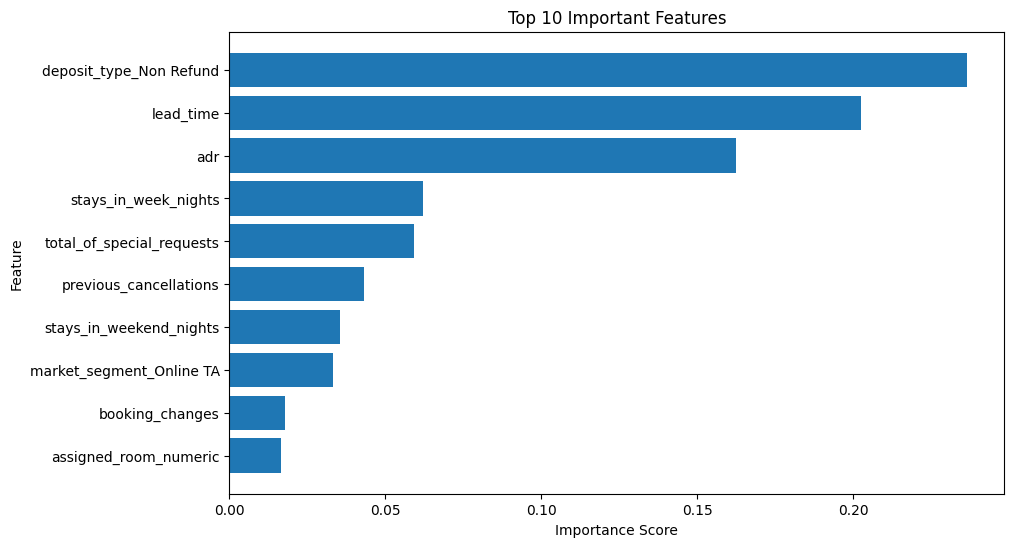

                                           Feature  Importance
43                         deposit_type_Non Refund    0.236543
0                                        lead_time    0.202514
10                                             adr    0.162493
2                             stays_in_week_nights    0.061928
11                       total_of_special_requests    0.059032
7                           previous_cancellations    0.043252
1                          stays_in_weekend_nights    0.035394
23                        market_segment_Online TA    0.033175
9                                  booking_changes    0.017682
13                           assigned_room_numeric    0.016521
3                                           adults    0.015498
46                         customer_type_Transient    0.013665
12                           reserved_room_numeric    0.010498
14                              hotel_Resort Hotel    0.009383
4                                         children    0

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances from the trained model
importance_scores = dt_classifier.feature_importances_

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores}).sort_values(by='Importance', ascending=False)

# Visualize the top important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

# Display the ranked features
print(feature_importance_df)

`deposit_type_Non Refund`: This feature has the highest importance, suggesting that whether a deposit is non-refundable plays a critical role in determining if a booking will be canceled. This makes sense as non-refundable deposits might deter cancellations

`lead_time`: The number of days between the booking date and the arrival date is the second most important feature. Longer lead times might increase the chance of cancellations as guests' plans change over time

`adr` (Average Daily Rate): The cost of the booking is also highly influential. Higher prices might lead to more cancellations, particularly if guests find better deals elsewhere

In conclusion, the feature importance plot highlights the key drivers of cancellations, with non-refundable deposits, lead time, and ADR emerging as the most critical factors. This insight not only aids model interpretation but also provides valuable information for hotel management in mitigating cancellations
